# Part A Run get all Needed Functions

In [1]:
!pip install --upgrade --no-cache-dir gdown
!pip install pytorch_lightning &> /dev/null
!gdown 1YuFkOkeZ_3iaf71W1QfaZqqO9nZq_QUy
!gdown 1PDctbNuLSpxVU6MA-Qy6Unf_Q-bQf0jd
!gdown 1_fR9WLy10WRzlZQBaMv8BFkT4f_4xr99
!gdown 1oSiBPjyxMOaC496rLVQA-xG-fgK1ulcA
!gdown 1h6VQWmbq41cJ9O1WdRalc8iOsox2HCeO # pretrained backbone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1YuFkOkeZ_3iaf71W1QfaZqqO9nZq_QUy
To: /content/hw3_mycocodata_mask_comp_zlib.h5
100% 4.30M/4.30M [00:00<00:00, 133MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PDctbNuLSpxVU6MA-Qy6Unf_Q-bQf0jd
To: /content/hw3_mycocodata_labels_comp_zlib.npy
100% 269k/269k [00:00<00:00, 96.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_fR9WLy10WRzlZQBaMv8BFkT4f_4xr99
To: /content/hw3_mycocodata_img_comp_zlib.h5
100% 801M/801M [00:08<00:00, 95.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oSiBPjyxMOaC496rLVQA-xG-fgK1ulcA
To: /content/hw3_mycocodata_bboxes_comp_zlib.npy
100% 327k/327k [00:00<00:00, 115MB/s]
Downloading...
From: https://drive.google.com/uc?id=1h6VQWmbq41c

In [2]:
from sklearn import metrics
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
from inspect import modulesbyfile
from tqdm import tqdm
import h5py
import albumentations as A
from PIL import Image
from skimage.transform import resize
import warnings
from torchvision.models.detection.image_list import ImageList
from MaskHead import *
warnings.filterwarnings('ignore')
torch.set_printoptions(linewidth=100)

np.set_printoptions(linewidth=100)
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part B Run to Train model

In [13]:
# load the data into data.Dataset
device = 'cuda'

labels_og, bbox_og, imgs, masks_og= load_datset(viz=False)
dataset = BuildDataset(imgs, labels_og, bbox_og, masks_og)
pretrained_path='checkpoint680.pth'
backbone, rpn = pretrained_models_680(pretrained_path)

# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

# random split the dataset into training and testset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
masknet = MaskHead().to(device)

# push the randomized training data into the dataloader
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=dataset.collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate_fn)
batch_tr = len(train_loader)
batch_val = len(test_loader)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [15]:
model= MaskHead().to(device)
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath='/content/drive/My Drive/680/Final Project/model_partB/', every_n_epochs=1, filename='{epoch}_Model')
tb_logger = pl_loggers.TensorBoardLogger('')
# Train
# trainer = pl.Trainer(logger=tb_logger, max_epochs=36, callbacks=[checkpoint_callback], accelerator='cuda')          
trainer = pl.Trainer(logger=tb_logger, max_epochs=30, callbacks=[checkpoint_callback], accelerator='cuda', resume_from_checkpoint='/content/drive/My Drive/680/Final Project/model_partB/epoch=17_Model.ckpt')

trainer.fit(model, train_loader, test_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/My Drive/680/Final Project/model_partB/epoch=17_Model.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type       | Params
------------------------------------------------
0 | bceloss          | BCELoss    | 0     
1 | mask_conv_layers | Sequential | 2.6 M 
2 | boxmod           | BoxHead    | 13.9 M
------------------------------------------------
16.5 M    Trainable params
0         Non-trainable params
16.5 M    Total params
66.142    Total estimated model 

Sanity Checking: 0it [00:00, ?it/s]

Training: 2612it [00:00, ?it/s]

# Part C Run to get Results

In [16]:
def plot_graphs():
  
 # Training
  total_loss =  [177.24767166182147, 138.52391692537407, 131.77217578068436, 126.3572218193848, 123.16004291732808, 119.50282886041248, 116.24466387799016, 107.09541994407914, 104.50878511220353, 103.0367040864515, 101.81106712258668, 100.71092481805738, 98.81564940878837, 98.5757371746524, 98.40941324475641, 98.26293197136597, 98.12876268212717, 97.9961560157993]
  
  # Validation
  total_val_loss = [150.59209733626378, 133.3851985024719, 129.45941855807206, 128.60538936822832, 123.62387726870102, 121.94429120674135, 119.47881292860818, 115.96555331563039, 116.21190766562671, 116.54303716651742, 117.70053519118153, 118.30800952985625, 117.99692184734096, 118.35164105305024, 118.6520880241375, 118.86217625552587, 118.96418489416222, 119.13126967098144]
  
  # Training Loss vs Epochs
  plt.plot(range(len(total_loss)), total_loss, label="Train Loss")
  plt.plot(range(len(total_val_loss)), total_val_loss, label="Validation Loss")
  plt.title("Epoch Vs Total Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()


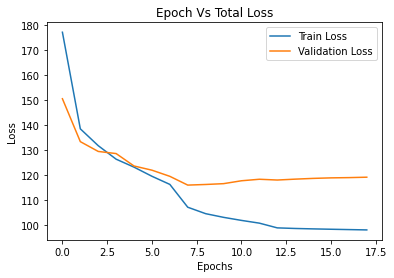

In [17]:
plot_graphs()

In [14]:
device = 'cuda'
model = MaskHead.load_from_checkpoint(checkpoint_path='/content/drive/My Drive/680/Final Project/model_partB/epoch=17_Model.ckpt')
model =  model.to(device)

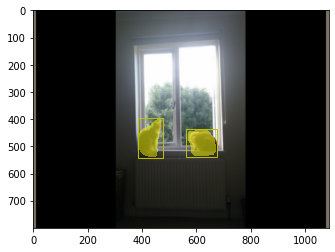

In [ ]:
for iter, batch in enumerate(train_loader, 0):
  images, labels, boxes, masks, indexes = batch
  break
images = images.to(device)
finconfs, finboxes, finlabs, maskpred, gt_masks = model.trainprocess(images, labels, boxes, masks)
finboxes = finboxes.cpu().detach().numpy()

c=['green', 'blue','yellow', 'red']
bc = ['g','b','y']
image_tar=images[0].cpu().numpy()
x_min = image_tar.min(axis=(1, 2), keepdims=True)
x_max = image_tar.max(axis=(1, 2), keepdims=True)
image_tar = (image_tar - x_min)/(x_max-x_min)
plt.imshow(np.transpose(image_tar, (1,2,0)))

nos = [0,1]

for no in nos:
  clas = finlabs[no]-1
  fullmask = torch.zeros((800,1088))
  box=finboxes[no]
  box[0] = np.clip(box[0], 0, 1088)
  box[1] = np.clip(box[1], 0, 800)
  box[2] = np.clip(box[2], 0, 1088)
  box[3] = np.clip(box[3], 0, 800)
  box = box.astype(int)
  mask_overlay= nn.functional.interpolate(maskpred[no][clas].reshape(1,1,28,28), (int(box[3]- box[1]), int(box[2]- box[0])), mode='bilinear')
  fullmask[box[1]:box[3],box[0]:box[2]]=mask_overlay[0][0]

  # fullgt = torch.zeros((800,1088))
  # gt_overlay= nn.functional.interpolate(gt_masks[no].reshape(1,1,28,28), (int(box[3]- box[1]), int(box[2]- box[0])), mode='bilinear')
  # fullgt[box[1]:box[3],box[0]:box[2]]= gt_overlay[0][0]

  plt.gca().add_patch(Rectangle((finboxes[no][0],finboxes[no][1]),(finboxes[no][2]-finboxes[no][0]),(finboxes[no][3]-finboxes[no][1]),linewidth=1,edgecolor=bc[clas],facecolor='none'))
  plt.imshow(fullmask.cpu().detach().numpy(), cmap=ListedColormap(['none', c[clas]]), alpha= 0.5)
  # plt.imshow(fullgt.cpu().detach().numpy(), cmap=ListedColormap(['none', 'red']), alpha=.5)
plt.show()